# Denoising Test

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functions
import matplotlib.pyplot as plt
import cv2 as cv

## Importing Test Image and Making Necessary functions

In [72]:
lion_img = cv.imread('/content/drive/My Drive/Colab Notebooks/Lion.jpg')
print(lion_img.shape)
lion_img = lion_img/255

(1024, 1024, 3)


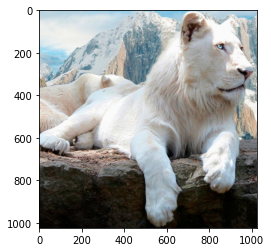

In [73]:
lion_img = lion_img[:,:,::-1]
plt.imshow(lion_img)

In [120]:
noise = np.random.randn(lion_img.shape[0],lion_img.shape[1],lion_img.shape[2])
noised_lion = lion_img + noise/1.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


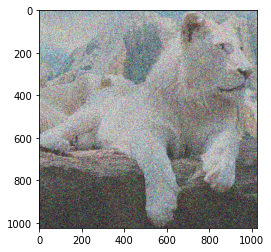

In [121]:
plt.imshow(noised_lion)

In [14]:
def partitioner(img,partsize):
  
  if(img.shape[0] != img.shape[1]):
    raise Exception("Input Image not Square")
  
  m = img.shape[0]
  partitioned = []

  for i in range(m//partsize):
    for j in range(m//partsize):
      aux = img[j*partsize:(j+1)*partsize,i*partsize:(i+1)*partsize]
      partitioned.append(aux)

  return np.array(partitioned)

In [64]:
def reassembler(parted):

  targetsize = np.sqrt(parted.shape[0])*parted.shape[1]
  partsize = parted.shape[0]
  
  cols = []

  for i in range(32):
    auxlist = []
    for j in range(32):
      auxlist.append(parted[j+(i*32)])
    cols.append(np.concatenate(auxlist))
  
  return np.concatenate(cols,axis=1)


In [37]:
inparts = partitioner(lion_img,32)
print(inparts.shape)

(1024, 32, 32, 3)


In [65]:
assembled = reassembler(inparts)

In [66]:
print(assembled.shape)

(1024, 1024, 3)


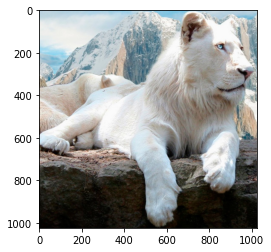

In [67]:
plt.imshow(assembled)

In [122]:
input = np.transpose(partitioner(noised_lion,32),axes=(0,3,1,2))
input = torch.from_numpy(input)
print(input.size())

torch.Size([1024, 3, 32, 32])


## Loading Model and Testing

In [84]:
class Conv(nn.Module):  ## Saved as Automod_test6

  def __init__(self):
    # Conv
    super(Conv,self).__init__()
    self.l1 = nn.Conv2d(3,96,(5,5))
    self.l2 = nn.Conv2d(96,120,(3,3))
    self.l3 = nn.Conv2d(120,180,(3,3))
    # Deconv
    self.rl3 = nn.ConvTranspose2d(180,120,(3,3))
    self.rl2 = nn.ConvTranspose2d(120,96,(3,3))
    self.rl1 = nn.ConvTranspose2d(96,3,(5,5))

  def forward(self,x):
    # Conv
    x1 = functions.relu(self.l1(x))
    x2 = functions.relu(self.l2(x1))
    x3 = functions.relu(self.l3(x2))
    # Deconv
    rx3 = functions.relu(self.rl3(x3))
    rx2 = functions.relu(self.rl2(rx3))
    rx1 = functions.relu(self.rl1(rx2))

    return rx1

In [86]:
net = Conv().double()
net.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Automod_test6.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [123]:
with torch.no_grad():
  X_output = net(input)
  print(X_output.size())
  X_output = X_output.numpy()

torch.Size([1024, 3, 32, 32])


In [124]:
X_output = np.transpose(X_output,axes=(0,2,3,1))
print(X_output.shape)

(1024, 32, 32, 3)


In [125]:
X_output_assembled = reassembler(X_output)
print(X_output_assembled.shape)

(1024, 1024, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


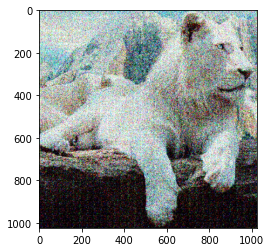

In [126]:
plt.imshow(X_output_assembled)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


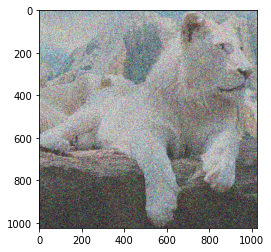

In [127]:
plt.imshow(noised_lion)